In [31]:
import matplotlib.pyplot as plt
import os
height = 8
width = height*1.6
plt.rcParams["figure.figsize"] = (width,height)
import numpy as np
plt.style.use('seaborn-colorblind')
import torch
from scipy.stats import entropy
from torch.distributions import Categorical

# import torch
# from torch.distributions import Categorical

# soft = np.full((10),0.1)
# max_val = Categorical(probs = torch.from_np(soft)).entropy().np()
# print(max_val)

plt.style.use('seaborn-colorblind')

def load(directory):
    metric_directory = directory+'/metrics/'
    ground_truths = list()
    outputs = list()
    
    for run in range(0,3):
        ground_truth = np.load(metric_directory+'ground-truth-run-'+str(run)+'.npy')
        output = np.load(metric_directory+'raw-softmax-run-'+str(run)+'.npy')
        ground_truths.append(ground_truth)
        outputs.append(output)
        
    ground_truths = np.array(ground_truths)
    outputs = np.array(outputs)
        
    mac_readings = np.load(directory+'/metrics/layerwise_macs.npy')
    
    return ground_truths,outputs,mac_readings

def get_label(directory):
    model = directory.split('/')[2]
    branch_weights = np.load(directory+"/metrics/branch-weights-"+model+".npy")
    string = model + ' ('
    for weight in branch_weights:
        weight = np.round(weight,decimals=3)
        string = string + str(weight) + " : "
    string = string[:-3]+')'
    return(string)

def get_exit_p(exit_readings):
    
    exit_p = np.zeros(4)

    for exit in range(len(exit_p)): 
        exit_p[exit] = np.count_nonzero(exit_readings==exit)
    return(exit_p/len(exit_readings))

def get_acc_profile(ground_truth,outputs):
    ground_truth = ground_truth.astype(int)
    number_class = outputs.shape[3]
    preds = np.argmax(outputs,axis=-1)
    correct = np.zeros_like(outputs)
    for run in range(correct.shape[0]):

        one_hot_labels = np.eye(number_class)[ground_truth[run,:]]
        one_hot_predictions = np.eye(number_class)[preds[run,:,:]]
            
        run_correct = np.equal(one_hot_labels,one_hot_predictions).astype(int)

        correct[run,:,:,:] = run_correct*one_hot_predictions

        
    n_values = correct.shape[-2]

    num_examples = n_values/number_class

    correct_count = np.sum(correct,axis=2)/num_examples
    mean_acc = np.mean(correct_count,axis=0)

    return mean_acc


In [62]:
#testing with single directory

mobilenet_layers = [2,6,10,16,20,36,48,61,79,98,117,135,154,172,191,210,214,218]
mobilenet_branches = [[0,3,4,5],[0,1,3,4,5,6,7,8],[0,1,2,3,4,6,7,8,9,10,11,12]]

resnet_layers = [1,2,3,16,31,46,61,62,63,64]
resnet_branches = [[0,1,2,6],[0,1,2,3,6,7],[0,1,2,3,4,6,7,8]]

directory = "../trained-models/BranchedResNet18/CIFAR100/wb102-b202-b302/"

gnd_trth, out, MAC = load(directory)

data = directory.split('/')[3]

if data == 'CIFAR100':
    meta_data = np.load('../data/cifar-100-python/meta',allow_pickle=True)
    label_names = np.array(meta_data['fine_label_names'])

(10000,)
(4, 10000, 100)
(4, 100)
accuracy profile:
[0.62306667 0.70113333 0.7193     0.7259    ]
accuracy correlation:
[[1.         0.96395617 0.9447394  0.93522632]
 [0.96395617 1.         0.97470339 0.9648485 ]
 [0.9447394  0.97470339 1.         0.99064483]
 [0.93522632 0.9648485  0.99064483 1.        ]]
[[0.62306667 0.6758618  0.67955105 0.67888078]
 [0.60060896 0.70113333 0.70110415 0.70038352]
 [0.58863563 0.68339704 0.7193     0.71910908]
 [0.58270834 0.67648744 0.71257083 0.7259    ]]


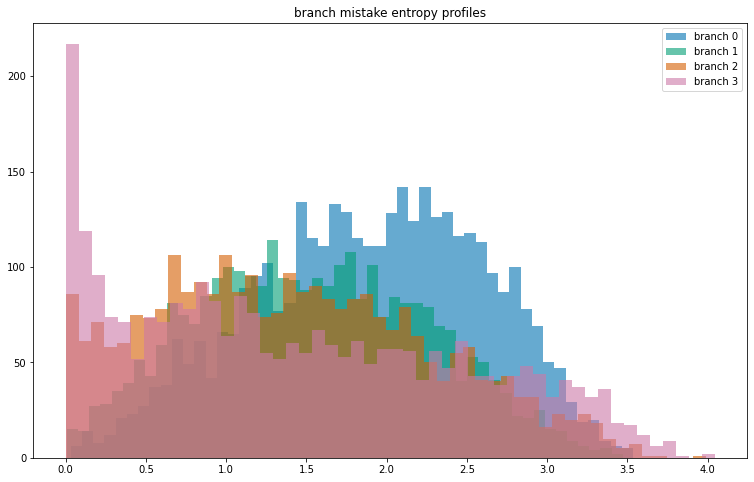

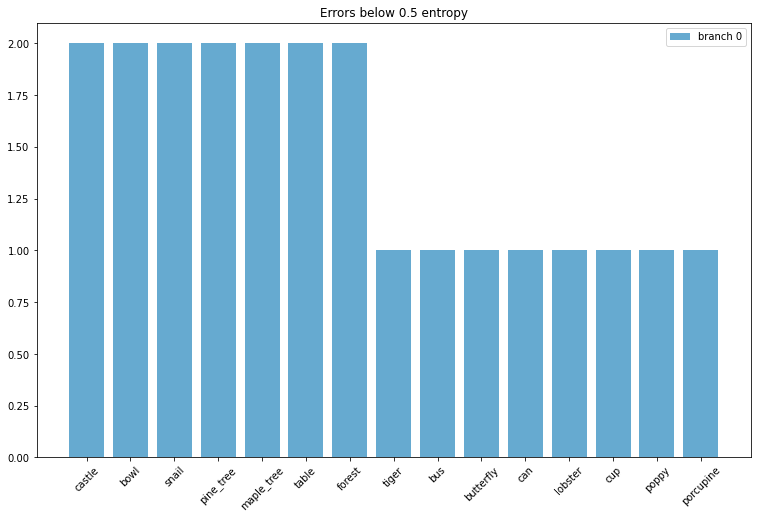

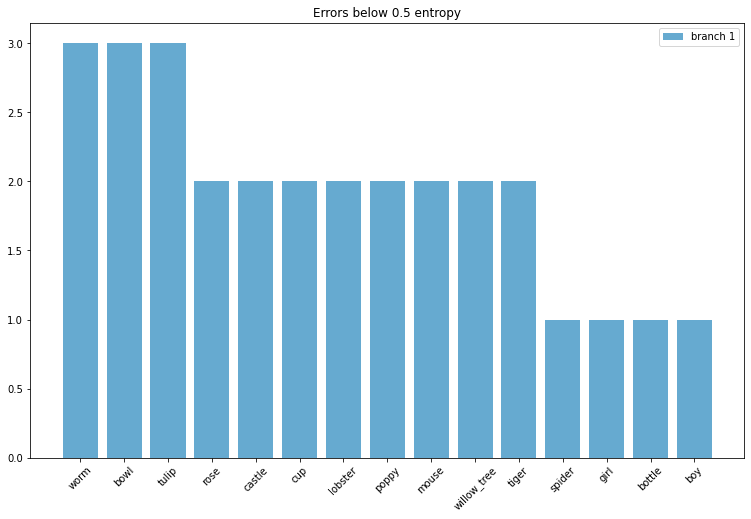

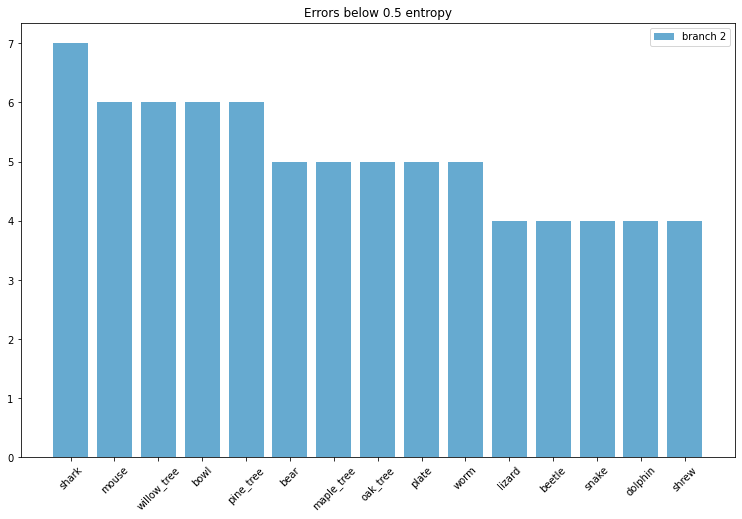

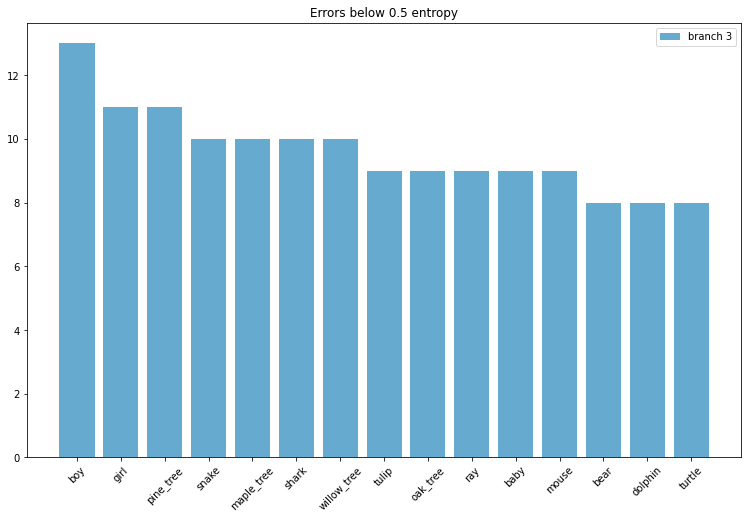

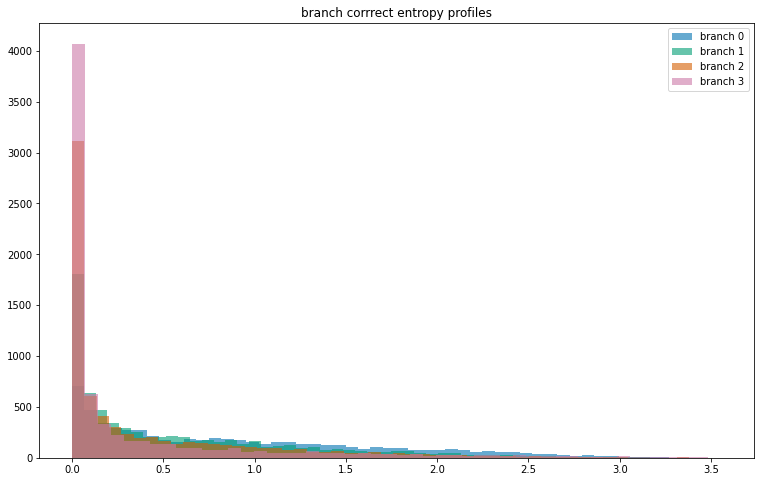

In [68]:
print(gnd_trth[0].shape)
print(out[0].shape)

n_inputs = out[0].shape[1]
n_branches = out[0].shape[0]

# covariance = np.zeros((n_branches,n_branches))
# for i in range(n_branches):
#     print(i)
#     for j in range(n_branches):
#         print(j)
#         inner_product = np.dot(out[0,i].T,out[0,j])
#         covariance[i,j] = np.cov

acc_prof = get_acc_profile(gnd_trth,out)
mean_acc = acc_prof.mean(axis=1)
branch_correlation = np.corrcoef(acc_prof)

print(acc_prof.shape)
print('accuracy profile:')
print(mean_acc)
print('accuracy correlation:')
print(branch_correlation)

branch_performance = branch_correlation*mean_acc

print(branch_performance)

incorrect = [[],[],[],[]]
correct = [[],[],[],[]]
bad_mistake_list = [[],[],[],[]]

# for i in np.random.randint(0,n_inputs,10):
for i in range(n_inputs):
    # print('\ninput ',i,'( label:',int(gnd_trth[0,i]),', final prediction:',int(np.argmax(out[0,-1,i,:])),') top 5 predictions:')
    for branch in range(4):
        ind = out[0,branch,i,:].argsort()[-5:]
        ent = entropy(out[0,branch,i,:])
        # print('Branch',branch,' - ',ind,np.round(out[0,branch,i,ind],5),np.argmax(out[0,branch,i,:]), 'entropy:', ent)

        if int(gnd_trth[0,i]) != ind[-1]:
            incorrect[branch].append(ent)
            if ent < 0.2:
                bad_mistake_list[branch].append(int(gnd_trth[0,i]))
        else:
            correct[branch].append(ent)



In [ ]:


for i in range(n_branches):
    plt.hist(incorrect[i],bins=50,alpha=0.6,label=('branch ' + str(i)))
    plt.title('branch mistake entropy profiles')
plt.legend()
plt.show()

top_n = 15
for i in range(n_branches):
    values,counts = np.unique(bad_mistake_list[i],return_counts=True)
    ordered_idxs = np.flip(np.argsort(counts))
    class_indexes= values[ordered_idxs][0:top_n]
    plt.bar(np.arange(0,top_n),counts[ordered_idxs][0:top_n],alpha=0.6,label=('branch ' + str(i)))
    plt.title('Errors below 0.5 entropy')
    plt.xticks(np.arange(0,top_n),label_names[values[ordered_idxs][0:top_n]],rotation = 45)
    plt.legend()
    plt.show()

for i in range(n_branches):
    plt.hist(correct[i],bins=50,alpha=0.6,label=('branch ' + str(i)))
    plt.title('branch corrrect entropy profiles')
plt.legend()
plt.show()


In [35]:
inp = np.random.randint(0,gnd_trth[0,:].shape[0])
single_mat = (out[0,:,inp,:])
inp_class = gnd_trth[0,inp]
print('input:',inp,'\tclass:',int(inp_class))

max_entropy = np.log(single_mat.shape[1])

print('output shape:',single_mat.shape)



for branch in range(single_mat.shape[0]):
    print('\nBranch',branch+1)
    cov = np.corrcoef(single_mat[:branch+1,:])
    ent = entropy(single_mat[:branch+1,:],axis=1)
    print(ent.shape)
    branch_prediction = np.argmax(single_mat[branch,:])

    predictions = np.argmax(single_mat[:branch+1,:],axis=1)
    one_hot = np.zeros_like(single_mat[:branch+1,:])
    one_hot[:branch+1,predictions] = 1
    one_hot_probs = single_mat[:branch+1,:]*one_hot
    total_one_hot = np.sum(one_hot_probs,axis=0)

    confidence_weighting = np.power(1-(ent/max_entropy),1/2*(np.arange(1,branch+2))) #(1-(ent[:, np.newaxis]/max_entropy))

    voting_softmax = np.sum(single_mat[:branch+1,:]*confidence_weighting[:,np.newaxis],axis=0)
    #normalise
    voting_softmax = voting_softmax/np.sum(voting_softmax)
    vote_ent = entropy(voting_softmax)

    print('Correct:',branch_prediction==inp_class)
    print('Voting Correct:',np.argmax(voting_softmax)==inp_class)
    print('Entropy:',ent,'Normalised Entropy:',ent/max_entropy)
    print('Voting Entropy:',vote_ent,'Voting Normalised Entropy:',vote_ent/max_entropy)
    print('Voting Confidences:',confidence_weighting)

    print('Covariance Matrix:',cov.shape)
    print(cov)
    ind = single_mat[branch,:].argsort()[-5:]
    print(ind,np.round(single_mat[branch,ind],5))

    ind = voting_softmax.argsort()[-5:]
    print(ind,np.round(voting_softmax[ind],5))

    
    ind = total_one_hot.argsort()[-5:]
    print(ind,np.round(total_one_hot[ind],5))

    if branch > 0:
        cov_change = cov[-2,-1]
    
    else:
        cov_change = 1.0

    print('Latest Covariance:',cov_change)
    print('Normalised Entropy/Covariance Change:',ent/max_entropy/cov_change)

input: 6732 	class: 6
output shape: (4, 100)

Branch 1
(1,)
Correct: True
Voting Correct: True
Entropy: [1.37176407] Normalised Entropy: [0.29787478]
Voting Entropy: 1.3717640685678203 Voting Normalised Entropy: 0.29787478272607915
Voting Confidences: [0.83792912]
Covariance Matrix: ()
1.0
[15 79 45 29  6] [0.01925 0.03076 0.04388 0.16134 0.65862]
[15 79 45 29  6] [0.01925 0.03076 0.04388 0.16134 0.65862]
[28 27 37 99  6] [0.      0.      0.      0.      0.65862]
Latest Covariance: 1.0
Normalised Entropy/Covariance Change: [0.29787478]

Branch 2
(2,)
Correct: True
Voting Correct: True
Entropy: [1.37176407 0.59016454] Normalised Entropy: [0.29787478 0.1281526 ]
Voting Entropy: 1.031047095730531 Voting Normalised Entropy: 0.2238890321290717
Voting Confidences: [0.83792912 0.8718474 ]
Covariance Matrix: (2, 2)
[[1.         0.98130576]
 [0.98130576 1.        ]]
[79 31 89 29  6] [0.0055  0.007   0.0104  0.05636 0.88894]
[15 79 45 29  6] [0.00974 0.01788 0.02272 0.10781 0.77606]
[28 27 37 99

In [36]:
test = np.array([0,0,0,0,0,0,0,0,0.5,0.5])

print(entropy(test)/np.log(len(test)))

test = np.array([0,0,0,0,0,0,0,0,0.1,0.9])

print(entropy(test)/np.log(len(test)))


test = np.array([0,0,0,0.5,0.5])

print(entropy(test)/np.log(len(test)))

test = np.array([0,0,0,0.1,0.9])

print(entropy(test)/np.log(len(test)))

one = np.array([0,0,0,0,0,0,0.1])
two = np.array([0,0,0,0,0,0.1,0.1])

print(np.dot(one,two))

0.30102999566398114
0.14118174150460758
0.43067655807339306
0.2019854079986195
0.010000000000000002
